In [2]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

/home/matevz/.pyenv/versions/3.6.13/envs/hpvm/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
labels = [
    "Walking",
    "W. Upstairs",
    "W. Downstairs",
    "Sitting",
    "Standing",
    "Lying",
]

segments = []
with open("model_log") as f:
    lines_raw = [l.strip() for l in f.readlines()]
    new_segment = None
    for l in lines_raw:
        if l == "begin":
            new_segment = []
        elif l == "end":
            segments.append(new_segment)
            new_segment = None
        else:
            new_segment.append(l)

df = pd.DataFrame(
    [s.split() for seg in segments for s in seg],
    columns=["conf", "true", "pred", 0, 1, 2, 3, 4, 5],
).astype({
    "conf": "str",
    "true": "int",
    "pred": "int",
    0: "float", 1: "float", 2: "float", 3: "float", 4: "float", 5: "float",
})
del segments

sm_c = df.loc[:, [0, 1, 2, 3, 4, 5]]
df["min"] = sm_c.min(axis=1)
df["max"] = sm_c.max(axis=1)


def max_2_difference(row: pd.Series):
    max2 = row.nlargest(2).values
    return max2[0] - max2[1]


df["max-max2"] = sm_c.apply(max_2_difference, axis=1, result_type='expand')
df["var"] = sm_c.var(axis=1)
df["max-min"] = df["max"]-df["min"]
df["correct"] = (df["true"] == df["pred"]).astype(int)

df


,conf,true,pred,0,1,2,3,4,5,min,max,max-max2,var,max-min,correct
0,conf0,5,5,3.701790e-07,3.966620e-07,5.709420e-06,5.185520e-07,6.763940e-09,9.999930e-01,6.763940e-09,0.999993,0.999987,0.166664,0.999993,1
1,conf0,4,3,4.426000e-07,3.186520e-06,7.070340e-06,9.999800e-01,5.963570e-06,2.873400e-06,4.426000e-07,0.999980,0.999973,0.166659,0.999980,0
2,conf0,3,3,3.288730e-07,2.117270e-06,4.556640e-06,9.999890e-01,2.253490e-06,1.903190e-06,3.288730e-07,0.999989,0.999984,0.166662,0.999989,1
3,conf0,0,0,1.000000e+00,1.225780e-10,2.113500e-11,4.788470e-11,3.392860e-12,2.703340e-11,3.392860e-12,1.000000,1.000000,0.166667,1.000000,1
4,conf0,3,3,4.424070e-07,2.920820e-06,6.369380e-06,9.999850e-01,3.083820e-06,2.628650e-06,4.424070e-07,0.999985,0.999979,0.166661,0.999985,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14495,conf9,3,3,2.051490e-03,8.476200e-03,2.346560e-01,7.230000e-01,1.317950e-02,1.863720e-02,2.051490e-03,0.723000,0.488344,0.082345,0.720949,1
14496,conf9,1,2,5.461050e-03,2.782110e-01,6.934100e-01,3.677390e-03,1.227080e-02,6.968780e-03,3.677390e-03,0.693410,0.415199,0.078359,0.689733,0
14497,conf9,1,1,6.430520e-03,9.597580e-01,3.134830e-02,6.544580e-04,1.176850e-03,6.315200e-04,6.315200e-04,0.959758,0.928410,0.151099,0.959126,1
14498,conf9,4,4,4.305800e-04,1.798270e-03,4.838590e-02,3.856110e-03,9.449260e-01,6.032690e-04,4.305800e-04,0.944926,0.896540,0.145716,0.944495,1


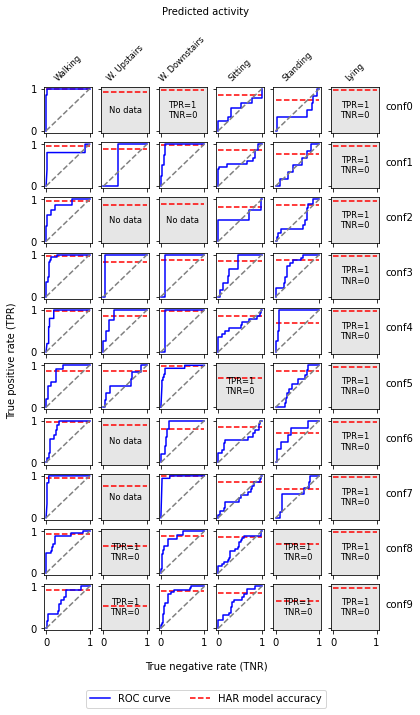

In [4]:
def do():
    from sklearn.model_selection import train_test_split, cross_validate
    from sklearn.naive_bayes import GaussianNB, MultinomialNB
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, plot_roc_curve, f1_score
    from matplotlib.lines import Line2D

    nlabels = len(df["true"].unique())
    nconfs = len(df["conf"].unique())


    accuracies = df.groupby(["conf", "true"]).agg({'correct': 'sum', 'pred': 'count'})
    accuracies["acc"] = accuracies["correct"] / accuracies["pred"]

    fig, axs = plt.subplots(nrows=nconfs, ncols=nlabels, figsize=(6, 10), sharex=True, sharey=True)
    for i, (conf, grpc) in enumerate(df.groupby(["conf"])):
        for j, (label, grp) in enumerate(grpc.groupby(["pred"])):

            ax = axs[i, label]

            feats = ["max", "max-max2"]
            clz = "correct"
            X, y = grp.loc[:, feats], grp.loc[:, clz]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            acc = accuracies.loc[conf].loc[label].acc

            ax.set_ylim(-0.05, 1.05)
            ax.hlines(acc, 0, 1, colors='r', linestyles='--')

            classifier = GaussianNB()

            classifier.fit(X_train, y_train)

            y_pred = classifier.predict(X_test)

            plot_kw = dict(c='b')

            def text(s): return ax.text(0.5, 0.5, s, ha='center', va='center', fontsize='small')

            if np.all(y_pred == 0):
                # TPR = 0
                # TNR = 1
                ax.set_facecolor((0.9, 0.9, 0.9))
                text("TPR=0\nTNR=1")
            elif np.all(y_pred == 1):
                # TPR = 1
                # TNR = 0
                ax.set_facecolor((0.9, 0.9, 0.9))
                text("TPR=1\nTNR=0")
            elif np.any(y_test == 0) and np.any(y_test == 1):
                # else:
                # dsp = plot_roc_curve(classifier, X_test, y_test, ax=ax, pos_label=1, name=f"Predicting correct")
                dsp = plot_roc_curve(classifier, X_test, y_test, ax=ax, pos_label=0,
                                    name=f"Predicting incorrect", **plot_kw)
                ax.plot([0, 1], [0, 1], '--', c='gray')
                ax.legend().remove()
            else:
                text("No data")
                ax.set_facecolor((0.9, 0.9, 0.9))

            ax.set_ylabel("")
            ax.set_xlabel("")

            if label == len(labels)-1:
                ax.text(1.2, 0.5, conf)

            if i == 0:
                ax.set_title(f"{labels[label]}", rotation=45, fontsize='small')

    fig.text(0.5, 0.98, "Predicted activity", ha='center')  # x

    fig.text(0.5, 0.07, "True negative rate (TNR)", ha='center')  # x
    fig.text(0.04, 0.5, "True positive rate (TPR)", va='center', rotation='vertical')  # y

    legend_elements = [Line2D([0], [0], c='b', ls='-', label='ROC curve'),
                    Line2D([0], [0], c='r', ls='--', label='HAR model accuracy'), ]
    fig.legend(handles=legend_elements, ncol=2, loc='center', bbox_to_anchor=(0, 0.03, 1, 0))


    plt.savefig("roc-confidence-bayes.pdf", bbox_inches='tight')
    plt.show()

do()


/home/matevz/.pyenv/versions/3.6.13/envs/hpvm/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/matevz/.pyenv/versions/3.6.13/envs/hpvm/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/matevz/.pyenv/versions/3.6.13/envs/hpvm/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/matevz/.pyenv/versions/3.6.13/envs/hpvm/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_spl

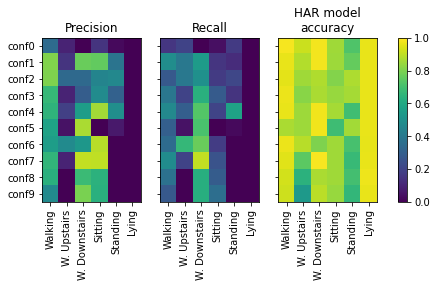

In [16]:
def do():
    from sklearn.model_selection import train_test_split, cross_validate
    from sklearn.naive_bayes import GaussianNB, MultinomialNB
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, plot_roc_curve, f1_score, make_scorer, precision_score, recall_score
    from matplotlib.lines import Line2D
    from sys import stderr

    nlabels = len(df["true"].unique())
    nconfs = len(df["conf"].unique())


    accuracies = df.groupby(["conf", "true"]).agg({'correct': 'sum', 'pred': 'count'})
    accuracies["acc"] = accuracies["correct"] / accuracies["pred"]

    feats = ["max", "max-max2"]
    clz = "correct"

    score_grid_p = np.zeros((nconfs, nlabels))
    score_grid_r = np.zeros((nconfs, nlabels))
    score_grid_har = np.zeros((nconfs, nlabels))

    pos_label = 0
    precision_scorer = make_scorer(precision_score, pos_label=pos_label, zero_division=0)
    recall_scorer = make_scorer(recall_score, pos_label=pos_label, zero_division=0)

    for i, (conf, grpc) in enumerate(df.groupby(["conf"])):
        for j, (label, grp) in enumerate(grpc.groupby(["pred"])):

            X, y = grp.loc[:, feats], grp.loc[:, clz]

            acc = accuracies.loc[conf].loc[label].acc

            classifier = GaussianNB()

            scores = cross_validate(classifier, X, y, scoring={
                                    'p': precision_scorer, 'r': recall_scorer})

            score_grid_p[i, j] = scores["test_p"].mean()
            score_grid_r[i, j] = scores["test_r"].mean()
            score_grid_har[i, j] = acc


    def do_imshow(ax, arr: np.array, *args, **kwargs):
        plt.imshow(arr, vmin=0, vmax=1, *args, **kwargs)


    fig, axs = plt.subplots(1, 3, sharey=True)

    plt.setp(axs,
            xticks=np.arange(nlabels), xticklabels=[l.replace("\n", " ") for l in labels],
            yticks=np.arange(nconfs), yticklabels=df["conf"].unique())

    for ax in axs:
        plt.setp(ax.get_xticklabels(), rotation='vertical')

    cmap = None

    axs[0].set_title("Precision")
    axs[0].imshow(score_grid_p, vmin=0, vmax=1, cmap=cmap)

    axs[1].set_title("Recall")
    axs[1].imshow(score_grid_r, vmin=0, vmax=1, cmap=cmap)

    axs[2].set_title("HAR model\naccuracy")
    im = axs[2].imshow(score_grid_har, vmin=0, vmax=1, cmap=cmap)

    (_, y0, _, hig) = axs[2].get_position().bounds

    # fig.subplots_adjust(right=0.8)
    # put colorbar at desire position
    cbar_ax = fig.add_axes([0.95, y0, 0.02, hig])
    fig.colorbar(im, cax=cbar_ax)


    plt.savefig("grid-confidence-bayes.pdf", bbox_inches='tight')
    plt.show()

do()


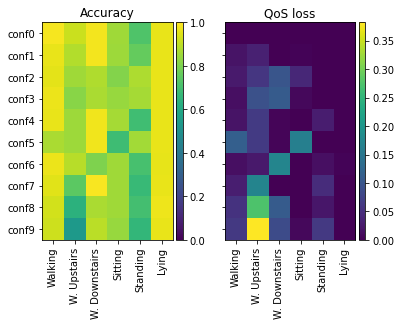

In [15]:
def do():
    from sklearn.model_selection import train_test_split, cross_validate
    from sklearn.naive_bayes import GaussianNB, MultinomialNB
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, plot_roc_curve, f1_score, make_scorer, precision_score, recall_score
    from matplotlib.lines import Line2D
    from sys import stderr
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    nlabels = len(df["true"].unique())
    nconfs = len(df["conf"].unique())


    accuracies = df.groupby(["conf", "true"]).agg({'correct': 'sum', 'pred': 'count'})
    accuracies["acc"] = accuracies["correct"] / accuracies["pred"]

    feats = ["max", "max-max2"]
    clz = "correct"

    score_grid_acc = np.zeros((nconfs, nlabels))
    score_grid_qos = np.zeros((nconfs, nlabels))

    pos_label = 0
    precision_scorer = make_scorer(precision_score, pos_label=pos_label, zero_division=0)
    recall_scorer = make_scorer(recall_score, pos_label=pos_label, zero_division=0)

    for i, (conf, grpc) in enumerate(df.groupby(["conf"])):
        for j, (label, grp) in enumerate(grpc.groupby(["pred"])):

            X, y = grp.loc[:, feats], grp.loc[:, clz]

            acc = accuracies.loc[conf].loc[label].acc

            score_grid_acc[i, j] = acc
            score_grid_qos[i, j] = max(accuracies.loc["conf0"].loc[label].acc - acc,0)


    def do_imshow(ax, arr: np.array, *args, **kwargs):
        plt.imshow(arr, vmin=0, vmax=1, *args, **kwargs)


    fig, axs = plt.subplots(1, 2, sharey=True)

    plt.setp(axs,
            xticks=np.arange(nlabels), xticklabels=[l.replace("\n", " ") for l in labels],
            yticks=np.arange(nconfs), yticklabels=df["conf"].unique())

    for ax in axs:
        plt.setp(ax.get_xticklabels(), rotation='vertical')

    cmap = None

    axs[0].set_title("Accuracy")
    im0 = axs[0].imshow(score_grid_acc, vmin=0, vmax=1, cmap=cmap)
    divider0 = make_axes_locatable(axs[0])
    cax0 = divider0.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im0, cax=cax0)


    axs[1].set_title("QoS loss")
    im1 = axs[1].imshow(score_grid_qos, cmap=cmap)
    divider1 = make_axes_locatable(axs[1])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im1, cax=cax1)

    plt.savefig("grid-accuracy-and-qos.pdf", bbox_inches='tight')
    plt.show()
do()